In [ ]:
print('test')

# Sheet

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use('dark_background')
figure(figsize=(16, 8), dpi=60)
plt.rcParams["figure.figsize"] = (18,5)

from fin_func import *
from os import listdir
from os.path import isfile, join
from pathlib import *
import pandas as pd

data_path = Path('./data')

fin_headers = ['date', 'year', 'month', 'credit_or_debet', 'amount', 'credit', 'debet', 'i_number', 'i_name', 'e_number', 'e_name', 'internal_or_external', 'e_type', 'e_official_name', 'description', 'payment_type']

pri_inkomen, pri_boodschappen, pri_fun, pri_overig, pri_abbo, pri_stack, pri_stack_kaakoperatie, huis_inkomen_en_lasten, huis_klussen, huis_huishoudelijk, huis_spaar = [None] * 11
df_pri_inkomen, df_pri_boodschappen, df_pri_fun, df_pri_overig, df_pri_abbo, df_pri_stack, df_pri_stack_kaakoperatie, df_huis_inkomen_en_lasten, df_huis_klussen, df_huis_huishoudelijk, df_huis_spaar = [None] * 11

labels = {
    'NL25KNAB0604860706': 'pri_inkomen',
    'NL60KNAB0604871716': 'pri_boodschappen',
    'NL54KNAB0604873182': 'pri_fun',
    'NL55KNAB0604872291': 'pri_overig',
    'NL08KNAB0604887493': 'pri_abbo',
    '57347285': 'pri_stack',
    '57441905': 'pri_stack_kaakoperatie',
    'NL02KNAB0407458360': 'huis_inkomen_en_lasten',
    'NL45KNAB0407464085': 'huis_klussen',
    'NL13KNAB0407465243': 'huis_huishoudelijk',
    '57857884': 'huis_spaar',
    'NL55INGB0798628839': 'huis_hypotheek',
    'NL06RABO0154599808': 'pri_oud',
    '57673844': 'pri_stack_oud',
    '60010259': 'pri_stack_oud2',
}

fin_data = []
fin_pandas = []
csv_paths = [f for f in listdir(data_path) if isfile(join(data_path, f))]

for i, cvs_path in enumerate(csv_paths):

    path = data_path / cvs_path
    account_number, account_type, year = parse_csv_knab(cvs_path)

    label = labels[account_number]

    s = label.split('_')
    account_name, account_category = (s.pop(0), '_'.join(s))

    df = pd.read_csv(path, skiprows=1, sep=';', decimal=',')
    df['Bedrag'] = df['Bedrag'].astype(float)

    df['Transactiedatum'] = pd.to_datetime(df['Transactiedatum'], dayfirst=True)
    df['Year'] = df['Transactiedatum'].dt.year
    df['Month'] = df['Transactiedatum'].dt.month

    def transform(c):
        c['Credit'] = c['Bedrag'] if c['CreditDebet'] == 'C' else 0
        c['Debet'] = c['Bedrag'] if c['CreditDebet'] == 'D' else 0
        c['RekeningnummerNaam'] = labels[c['Rekeningnummer']] if c['Rekeningnummer'] in labels else '?'
        c['TegenrekeningnummerNaam'] = labels[c['Tegenrekeningnummer']] if c['Tegenrekeningnummer'] in labels else c['Tegenrekeninghouder']
        c['InternalExternal'] = 'I' if c['Tegenrekeningnummer'] in labels else 'E'
        c['e_type'] = ('P' if c['Tegenrekeningnummer'].startswith('NL') else 'S') if c['InternalExternal'] == 'I' else None

        return c

    df = df.apply(transform, axis=1)
    df = df[['Transactiedatum', 'Year', 'Month', 'CreditDebet', 'Bedrag', 'Credit', 'Debet', 'Rekeningnummer', 'RekeningnummerNaam', 'Tegenrekeningnummer', 'TegenrekeningnummerNaam', 'InternalExternal', 'e_type', 'Tegenrekeninghouder', 'Omschrijving', 'Betaalwijze']]
    df.set_axis(fin_headers, axis=1, inplace=True)

    fin_pandas.append(df)

    account_info = {
        'path': path,
        'df': df,
        'account_name': account_name,
        'account_category': account_category,
        'account_number': account_number,
        'account_type': account_type,
        'year': year,
    }

    account_info = Struct(account_info)
    locals().update({label: account_info, f'df_{label}': df})
    fin_data.append(account_info)



In [2]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

print(df['e_name'].value_counts())
print(df['e_number'].value_counts())
print(df['payment_type'].value_counts())

df

Team Rockstars IT B.V.            10
itbureau                           1
Geobureau                          1
D.S.W. Zorgverzekeraar             1
MARINUS APARTMENTS AGATA BORYS     1
Sparen Opheffen RN                 1
KNAB                               1
Name: e_name, dtype: int64
NL03RABO0120771985              10
NL29KNAB0410169897               1
NL76INGB0007550684               1
NL45RABO0343685280               1
PL60105017641000009700639660     1
NL09RABO0350801363               1
80000872                         1
Name: e_number, dtype: int64
Ontvangen betaling            15
Vergoeding Overstapservice     1
Name: payment_type, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
2,2021-11-30,2021,11,C,820.00,820.00,0.0,NL25KNAB0604860706,pri_inkomen,NL29KNAB0410169897,itbureau,E,None,itbureau,foute boeking,Ontvangen betaling
13,2021-11-25,2021,11,C,15009.48,15009.48,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris november 2021, F40C84D04E9FE7EC",Ontvangen betaling
23,2021-11-01,2021,11,C,2216.98,2216.98,0.0,NL25KNAB0604860706,pri_inkomen,NL76INGB0007550684,Geobureau,E,None,Geobureau,belastingteruggave aan william,Ontvangen betaling
34,2021-10-05,2021,10,C,1327.34,1327.34,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris september 2021, FA8CDF5249F8CAEA",Ontvangen betaling
36,2021-09-29,2021,9,C,63.31,63.31,0.0,NL25KNAB0604860706,pri_inkomen,NL45RABO0343685280,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Mondzorg/202109108416/RELATIENUMMER:207025045/...,Ontvangen betaling
43,2021-09-24,2021,9,C,2033.33,2033.33,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris september 2021, 756010874F17312B",Ontvangen betaling
65,2021-08-25,2021,8,C,2028.13,2028.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris augustus 2021, B95F556746CEF0CB",Ontvangen betaling
75,2021-08-12,2021,8,C,420.34,420.34,0.0,NL25KNAB0604860706,pri_inkomen,PL60105017641000009700639660,MARINUS APARTMENTS AGATA BORYS,E,None,MARINUS APARTMENTS AGATA BORYS,Reservation no 1691 refund,Ontvangen betaling
88,2021-07-23,2021,7,C,2038.13,2038.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris juli 2021, C5AA0BE6401836D6",Ontvangen betaling
115,2021-06-25,2021,6,C,2038.13,2038.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris juni 2021, D5C0FF7D47B0999B",Ontvangen betaling


# Inkomen

In [6]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

print(df['e_name'].value_counts())

df

Team Rockstars IT B.V.            10
itbureau                           1
Geobureau                          1
D.S.W. Zorgverzekeraar             1
MARINUS APARTMENTS AGATA BORYS     1
Sparen Opheffen RN                 1
KNAB                               1
Name: e_name, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
2,2021-11-30,2021,11,C,820.00,820.00,0.0,NL25KNAB0604860706,pri_inkomen,NL29KNAB0410169897,itbureau,E,None,itbureau,foute boeking,Ontvangen betaling
13,2021-11-25,2021,11,C,15009.48,15009.48,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris november 2021, F40C84D04E9FE7EC",Ontvangen betaling
23,2021-11-01,2021,11,C,2216.98,2216.98,0.0,NL25KNAB0604860706,pri_inkomen,NL76INGB0007550684,Geobureau,E,None,Geobureau,belastingteruggave aan william,Ontvangen betaling
34,2021-10-05,2021,10,C,1327.34,1327.34,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris september 2021, FA8CDF5249F8CAEA",Ontvangen betaling
36,2021-09-29,2021,9,C,63.31,63.31,0.0,NL25KNAB0604860706,pri_inkomen,NL45RABO0343685280,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Mondzorg/202109108416/RELATIENUMMER:207025045/...,Ontvangen betaling
43,2021-09-24,2021,9,C,2033.33,2033.33,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris september 2021, 756010874F17312B",Ontvangen betaling
65,2021-08-25,2021,8,C,2028.13,2028.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris augustus 2021, B95F556746CEF0CB",Ontvangen betaling
75,2021-08-12,2021,8,C,420.34,420.34,0.0,NL25KNAB0604860706,pri_inkomen,PL60105017641000009700639660,MARINUS APARTMENTS AGATA BORYS,E,None,MARINUS APARTMENTS AGATA BORYS,Reservation no 1691 refund,Ontvangen betaling
88,2021-07-23,2021,7,C,2038.13,2038.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris juli 2021, C5AA0BE6401836D6",Ontvangen betaling
115,2021-06-25,2021,6,C,2038.13,2038.13,0.0,NL25KNAB0604860706,pri_inkomen,NL03RABO0120771985,Team Rockstars IT B.V.,E,None,Team Rockstars IT B.V.,"Salaris juni 2021, D5C0FF7D47B0999B",Ontvangen betaling


In [10]:
df_per_crediteur = df.groupby('e_name').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_crediteur.index

print(labels)

df_per_crediteur['credit'].iloc[:, 0]

Index(['D.S.W. Zorgverzekeraar', 'Geobureau', 'KNAB',
       'MARINUS APARTMENTS AGATA BORYS', 'Sparen Opheffen RN',
       'Team Rockstars IT B.V.', 'huis_hypotheek', 'huis_inkomen_en_lasten',
       'huis_klussen', 'itbureau', 'pri_abbo', 'pri_oud', 'pri_overig',
       'pri_stack', 'pri_stack_kaakoperatie', 'pri_stack_oud',
       'pri_stack_oud2'],
      dtype='object', name='e_name')


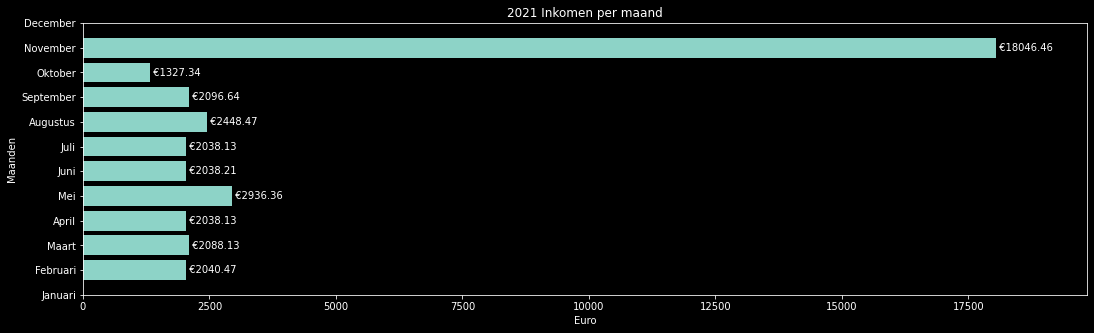

In [8]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']
df = df.loc[df['internal_or_external'] == 'E']

df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['credit'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title('2021 Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

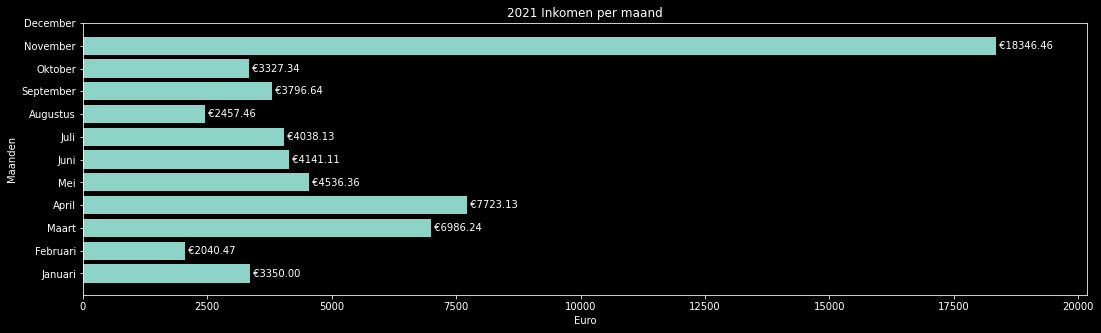

In [9]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'C']

df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['amount'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title('2021 Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

# Uitgaven

totale uitgaven € 34815.13


amount 
 
 
 
 
 count 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 internal_or_external 
 
 
 
 
 
 
 
 
 
 
 pri_overig 
 I 
 54 
 13189.83 
 1099.152500 
 244.256111 
 3.00 
 1500.00 
 
 
 pri_fun 
 I 
 25 
 1262.66 
 105.221667 
 50.506400 
 4.48 
 140.00 
 
 
 pri_boodschappen 
 I 
 16 
 3295.46 
 274.621667 
 205.966250 
 50.00 
 296.98 
 
 
 huis_inkomen_en_lasten 
 I 
 11 
 3558.97 
 296.580833 
 323.542727 
 2.00 
 1000.00 
 
 
 pri_abbo 
 I 
 11 
 2805.01 
 233.750833 
 255.000909 
 102.22 
 500.00 
 
 
 Knab 
 E 
 10 
 50.00 
 4.166667 
 5.000000 
 5.00 
 5.00 
 
 
 huis_hypotheek 
 I 
 6 
 3850.00 
 320.833333 
 641.666667 
 350.00 
 2100.00 
 
 
 itbureau 
 E 
 4 
 5820.00 
 485.000000 
 1455.000000 
 820.00 
 3000.00 
 
 
 namsool B.V. 
 E 
 2 
 101.20 
 8.433333 
 50.600000 
 1.20 
 100.00 
 
 
 STG MOLLIE PAYMENTS 
 E 
 1 
 25.00 
 2.083333 
 25.000000 
 25.00 
 25.00 
 
 
 STICHTING DERDENGELDEN BUCKAROO 
 E 
 1 
 7.00 
 0.583333 
 7.000000 
 7.00 
 7.00 
 
 
 huis_klussen 
 I 
 1 
 850.00 
 70.833333 
 850.000000 
 850.00 
 850.00

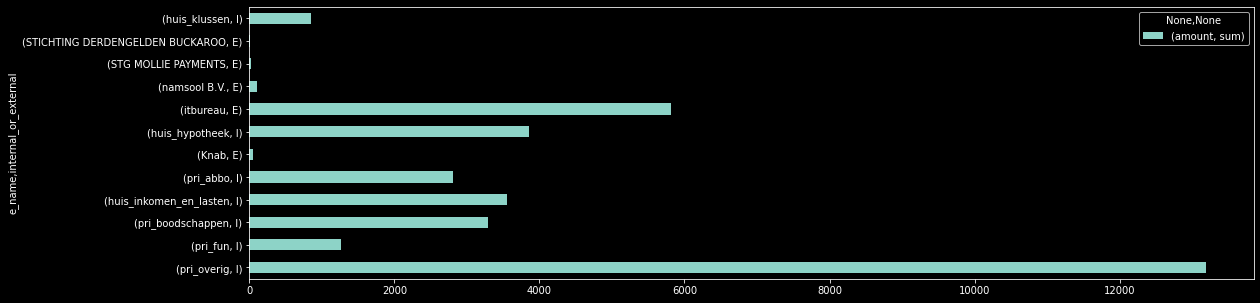

In [39]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']
df = df.loc[df['e_type'] != 'S']

df_per_category = df.groupby(['e_name', 'internal_or_external']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)
df_per_category[[('amount','sum')]].plot.barh()

print("totale uitgaven €", sum(df_per_category[('amount','sum')]))

df_per_category

In [13]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

pri_overig                         54
pri_fun                            25
pri_boodschappen                   16
huis_inkomen_en_lasten             11
pri_abbo                           11
Knab                               10
pri_stack                           7
huis_hypotheek                      6
itbureau                            4
pri_stack_kaakoperatie              4
namsool B.V.                        2
pri_stack_oud                       2
huis_klussen                        1
STICHTING DERDENGELDEN BUCKAROO     1
STG MOLLIE PAYMENTS                 1
Name: e_name, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-03,2021,12,D,100.0,0.0,100.0,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,NaN,Overboeking
1,2021-12-01,2021,12,D,5.0,0.0,5.0,NL25KNAB0604860706,pri_inkomen,80000208,Knab,E,None,Knab,Pakketkosten,Pakketkosten
3,2021-11-30,2021,11,D,820.0,0.0,820.0,NL25KNAB0604860706,pri_inkomen,NL29KNAB0410169897,itbureau,E,None,itbureau,NaN,Overboeking
4,2021-11-25,2021,11,D,8000.0,0.0,8000.0,NL25KNAB0604860706,pri_inkomen,57347285,pri_stack,I,S,W. J. Loosman,sparen,Overboeking
5,2021-11-25,2021,11,D,300.0,0.0,300.0,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,overige zaken,Overboeking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2021-01-25,2021,1,D,1000.0,0.0,1000.0,NL25KNAB0604860706,pri_inkomen,57347285,pri_stack,I,S,W. J. Loosman,NaN,Overboeking
202,2021-01-25,2021,1,D,500.0,0.0,500.0,NL25KNAB0604860706,pri_inkomen,NL08KNAB0604887493,pri_abbo,I,P,W. J. Loosman,NaN,Overboeking
203,2021-01-25,2021,1,D,500.0,0.0,500.0,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
204,2021-01-22,2021,1,D,100.0,0.0,100.0,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,budget feb 2021-02,Overboeking


In [14]:
df_per_account = df.groupby('i_name').agg({'amount': 'sum'})


labels = df_per_account.index

print(labels)

values = list(df_per_account['amount'])
values

Index(['pri_inkomen'], dtype='object', name='i_name')


[60015.13]

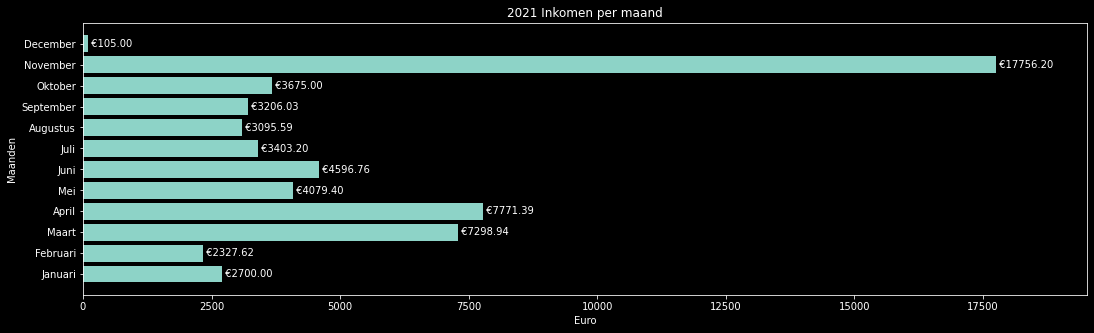

In [15]:
df_per_maand = df.groupby('month').agg({'credit': ['sum'], 'amount': 'sum'})

labels = df_per_maand.index
values = list(df_per_maand['amount'].iloc[:, 0])

# labels = df['month']
# values = df['credit']

maand_labels = ('Januari', 'Februari', 'Maart', 'April', 'Mei', 'Juni', 'Juli', 'Augustus', 'September', 'Oktober', 'November', 'December')
maand_nummers = (1,2,3,4,5,6,7,8,9,10,11,12)

fig, ax = plt.subplots()

hbars = ax.barh(labels, values, align='center')
ax.set_yticks(maand_nummers, labels=maand_labels)

ax.set_xlabel('Euro')
ax.set_ylabel('Maanden')
ax.set_title('2021 Inkomen per maand')

# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
ax.bar_label(hbars, fmt=' €%.2f')
ax.set_xlim(right=(max(values)*1.1))  # adjust xlim to fit labels

plt.show()

amount 
 
 
 
 
 sum 
 mean 
 min 
 max 
 
 
 month 
 e_name 
 
 
 
 
 
 
 
 
 1 
 huis_hypotheek 
 350.0 
 350.000000 
 350.0 
 350.0 
 
 
 pri_abbo 
 500.0 
 500.000000 
 500.0 
 500.0 
 
 
 pri_boodschappen 
 250.0 
 250.000000 
 250.0 
 250.0 
 
 
 pri_fun 
 100.0 
 100.000000 
 100.0 
 100.0 
 
 
 pri_overig 
 500.0 
 500.000000 
 500.0 
 500.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 11 
 pri_fun 
 138.0 
 46.000000 
 20.0 
 60.0 
 
 
 pri_overig 
 3010.0 
 501.666667 
 10.0 
 1500.0 
 
 
 pri_stack 
 8000.0 
 8000.000000 
 8000.0 
 8000.0 
 
 
 pri_stack_kaakoperatie 
 4000.0 
 2000.000000 
 1000.0 
 3000.0 
 
 
 12 
 pri_fun 
 100.0 
 100.000000 
 100.0 
 100.0 
 
 
 
 63 rows × 4 columns

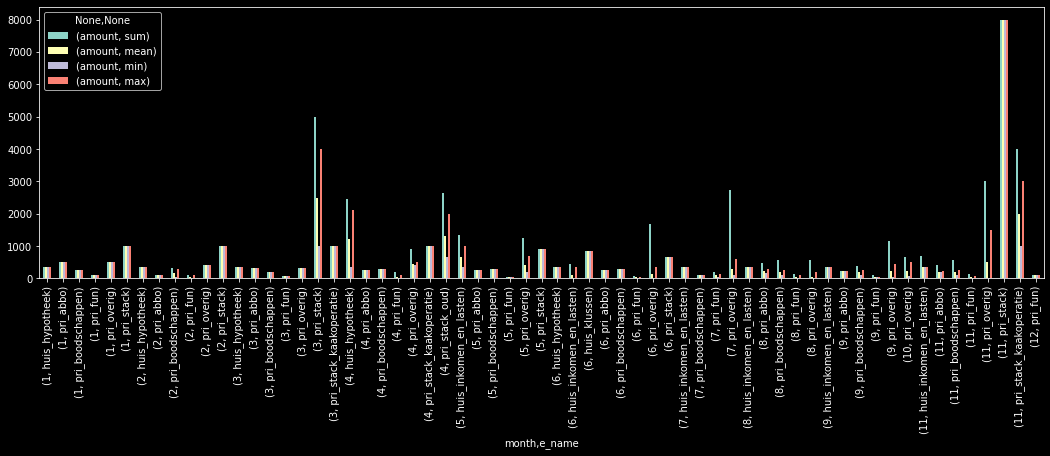

In [23]:
df = df_pri_inkomen
df = df.loc[df['credit_or_debet'] == 'D']
df = df.loc[df['internal_or_external'] == 'I']
df = df.loc[df['e_type'].isin(['P', 'S'])]

df_per_maand = df.groupby(['month', 'e_name']).agg({'amount': ['sum', 'mean', 'min', 'max']})

df_per_maand.plot.bar()
df_per_maand

amount 
 
 
 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 
 
 
 
 
 
 
 
 
 huis_hypotheek 
 3850.00 
 320.833333 
 641.666667 
 350.00 
 2100.00 
 
 
 huis_inkomen_en_lasten 
 3558.97 
 296.580833 
 323.542727 
 2.00 
 1000.00 
 
 
 huis_klussen 
 850.00 
 70.833333 
 850.000000 
 850.00 
 850.00 
 
 
 pri_abbo 
 2805.01 
 233.750833 
 255.000909 
 102.22 
 500.00 
 
 
 pri_boodschappen 
 3295.46 
 274.621667 
 205.966250 
 50.00 
 296.98 
 
 
 pri_fun 
 1262.66 
 105.221667 
 50.506400 
 4.48 
 140.00 
 
 
 pri_overig 
 13189.83 
 1099.152500 
 244.256111 
 3.00 
 1500.00 
 
 
 pri_stack 
 16550.00 
 1379.166667 
 2364.285714 
 650.00 
 8000.00 
 
 
 pri_stack_kaakoperatie 
 6000.00 
 500.000000 
 1500.000000 
 1000.00 
 3000.00 
 
 
 pri_stack_oud 
 2650.00 
 220.833333 
 1325.000000 
 650.00 
 2000.00

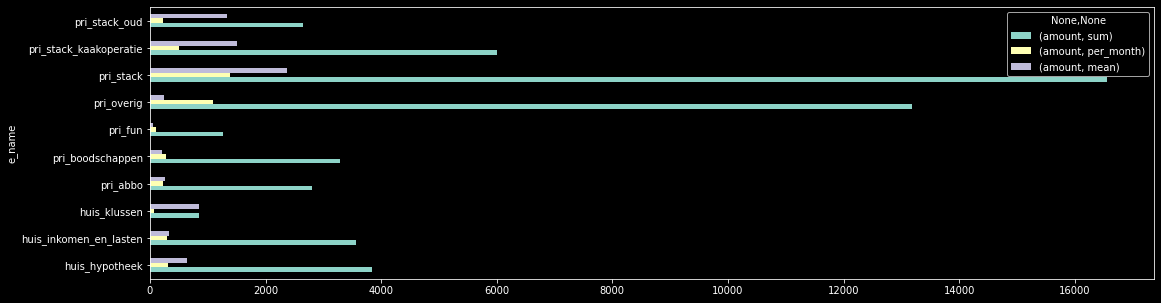

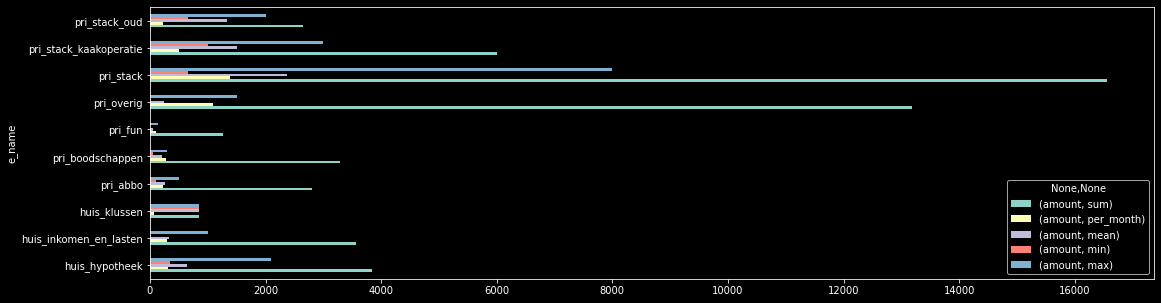

In [17]:
df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean']}).plot.barh()

df_per_category = df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']})
df_per_category.plot.barh()
df_per_category

In [18]:
df_pri_inkomen

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-03,2021,12,D,100.0,0.0,100.0,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,NaN,Overboeking
1,2021-12-01,2021,12,D,5.0,0.0,5.0,NL25KNAB0604860706,pri_inkomen,80000208,Knab,E,None,Knab,Pakketkosten,Pakketkosten
2,2021-11-30,2021,11,C,820.0,820.0,0.0,NL25KNAB0604860706,pri_inkomen,NL29KNAB0410169897,itbureau,E,None,itbureau,foute boeking,Ontvangen betaling
3,2021-11-30,2021,11,D,820.0,0.0,820.0,NL25KNAB0604860706,pri_inkomen,NL29KNAB0410169897,itbureau,E,None,itbureau,NaN,Overboeking
4,2021-11-25,2021,11,D,8000.0,0.0,8000.0,NL25KNAB0604860706,pri_inkomen,57347285,pri_stack,I,S,W. J. Loosman,sparen,Overboeking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2021-01-25,2021,1,D,500.0,0.0,500.0,NL25KNAB0604860706,pri_inkomen,NL55KNAB0604872291,pri_overig,I,P,W. J. Loosman,NaN,Overboeking
204,2021-01-22,2021,1,D,100.0,0.0,100.0,NL25KNAB0604860706,pri_inkomen,NL54KNAB0604873182,pri_fun,I,P,W. J. Loosman,budget feb 2021-02,Overboeking
205,2021-01-22,2021,1,D,250.0,0.0,250.0,NL25KNAB0604860706,pri_inkomen,NL60KNAB0604871716,pri_boodschappen,I,P,W. J. Loosman,boodschappengeld feb 2021-02,Overboeking
206,2021-01-22,2021,1,C,1200.0,1200.0,0.0,NL25KNAB0604860706,pri_inkomen,NL06RABO0154599808,pri_oud,I,P,W.J. Loosman,Budget februari 2021,Ontvangen betaling


## Beugel

In [19]:
df = df_pri_overig

old_costs = [
    130.0,
    5.44,
    58.12,
    8.15,
    240.0,
    241.19,
    41.44,
    41.44,
    41.44,
    41.44,
    45.7,
    93.03,
    41.44,
    41.44
]

old_costs_total = sum(old_costs)

print("old costs: €", old_costs_total)

df_beugel = df.loc[df['e_name'] == 'Infomedics B.V.']

print(df_beugel['amount'])

costs = sum(df_beugel['amount'])

costs = costs + old_costs_total

prediction = 12 * 42.77

inzet_kosten = 240.0 + 241.19

print("beugelkosten: €", costs)
print("wachten tot kaakoperatie: €", prediction)
print("beugel plaatsen: €", inzet_kosten)
print("beugel verwijderen en plaatsten: €", inzet_kosten)


old costs: € 1070.2700000000004
26     42.77
41     42.77
73     42.77
117    42.77
137    42.77
192    42.77
217    42.77
236    42.77
248    42.77
Name: amount, dtype: float64
beugelkosten: € 1455.2000000000003
wachten tot kaakoperatie: € 513.24
beugel plaatsen: € 481.19


## abbo

In [20]:
df = df_pri_abbo
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

D.S.W. Zorgverzekeraar                                         21
KPN - Mobiel                                                   10
PROTECT INVEST                                                  8
Transip B.V.                                                    4
SPOTIFY  SpotifyNL                                              3
SIMYO                                                           3
Stichting Cultuurbord via Mollie  STICHTING MOLLIE PAYMENTS     1
Stichting Cultuurbord via Mollie                                1
Spotify                                                         1
KPN BV                                                          1
pri_inkomen                                                     1
TLS BV inz. OV-Chipkaart                                        1
NS GROEP IZ NS REIZIGERS                                        1
ov-chipkaart/Trans Link Systems by                              1
NS GROEP N.V.                                                   1
Name: e_na

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-01,2021,12,D,2.00,0.0,2.00,NL08KNAB0604887493,pri_abbo,NL12DEUT7026116215,Stichting Cultuurbord via Mollie STICHTING MO...,E,None,Stichting Cultuurbord via Mollie STICHTING MO...,"Donation 6617c57934475d 2.00 Monthly, SD16-832...",Periodieke incasso
1,2021-12-01,2021,12,D,146.75,0.0,146.75,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 2207025045200028 / Omschrijving: Prem...,Periodieke incasso
2,2021-11-29,2021,11,D,9.99,0.0,9.99,NL08KNAB0604887493,pri_abbo,NL48ABNA0502830042,SPOTIFY SpotifyNL,E,None,SPOTIFY SpotifyNL,"SpotifyNL P1827313A3, C181637864343788",Periodieke incasso
3,2021-11-26,2021,11,D,7.00,0.0,7.00,NL08KNAB0604887493,pri_abbo,NL83INGB0007811682,SIMYO,E,None,SIMYO,"Simyo:0623335127, FACTUURNUMMER:67421805, A37C...",Periodieke incasso
5,2021-11-25,2021,11,D,37.50,0.0,37.50,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 1207025045112171 / Omschrijving: Gesp...,Periodieke incasso
6,2021-11-09,2021,11,D,18.32,0.0,18.32,NL08KNAB0604887493,pri_abbo,NL83INGB0000325513,KPN - Mobiel,E,None,KPN - Mobiel,"Factuur 02-11-2021, klantnummer 20198828494, k...",Periodieke incasso
7,2021-11-01,2021,11,D,146.75,0.0,146.75,NL08KNAB0604887493,pri_abbo,NL11RABO0343685310,D.S.W. Zorgverzekeraar,E,None,D.S.W. Zorgverzekeraar,Kenmerk: 4207025045200027 / Omschrijving: Prem...,Periodieke incasso
9,2021-10-29,2021,10,D,2.00,0.0,2.00,NL08KNAB0604887493,pri_abbo,NL51DEUT0265262461,Stichting Cultuurbord via Mollie,E,None,Stichting Cultuurbord via Mollie,Donation 6617c57934475d 2.00 Monthl,iDEAL
10,2021-10-28,2021,10,D,7.00,0.0,7.00,NL08KNAB0604887493,pri_abbo,NL83INGB0007811682,SIMYO,E,None,SIMYO,"Simyo:0623335127, FACTUURNUMMER:67061393, 1969...",Periodieke incasso
11,2021-10-27,2021,10,D,9.99,0.0,9.99,NL08KNAB0604887493,pri_abbo,NL48ABNA0502830042,SPOTIFY SpotifyNL,E,None,SPOTIFY SpotifyNL,"SpotifyNL P17A547A64, C451635185942815",Periodieke incasso


amount 
 
 
 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 
 
 
 
 
 
 
 
 
 D.S.W. Zorgverzekeraar 
 1989.25 
 165.770833 
 94.726190 
 37.50 
 146.75 
 
 
 KPN - Mobiel 
 188.54 
 15.711667 
 18.854000 
 17.97 
 26.11 
 
 
 KPN BV 
 0.01 
 0.000833 
 0.010000 
 0.01 
 0.01 
 
 
 NS GROEP IZ NS REIZIGERS 
 0.01 
 0.000833 
 0.010000 
 0.01 
 0.01 
 
 
 NS GROEP N.V. 
 0.01 
 0.000833 
 0.010000 
 0.01 
 0.01 
 
 
 PROTECT INVEST 
 380.00 
 31.666667 
 47.500000 
 47.50 
 47.50 
 
 
 SIMYO 
 23.32 
 1.943333 
 7.773333 
 7.00 
 9.32 
 
 
 SPOTIFY SpotifyNL 
 29.97 
 2.497500 
 9.990000 
 9.99 
 9.99 
 
 
 Spotify 
 9.99 
 0.832500 
 9.990000 
 9.99 
 9.99 
 
 
 Stichting Cultuurbord via Mollie 
 2.00 
 0.166667 
 2.000000 
 2.00 
 2.00 
 
 
 Stichting Cultuurbord via Mollie STICHTING MOLLIE PAYMENTS 
 2.00 
 0.166667 
 2.000000 
 2.00 
 2.00 
 
 
 TLS BV inz. OV-Chipkaart 
 20.00 
 1.666667 
 20.000000 
 20.00 
 20.00 
 
 
 Transip B.V. 
 72.27 
 6.022500 
 18.067500 
 9.67 
 32.07 
 
 
 ov-chipkaart/Trans Link Systems by 
 0.01 
 0.000833 
 0.010000 
 0.01 
 0.01 
 
 
 pri_inkomen 
 375.00 
 31.250000 
 375.000000 
 375.00 
 375.00

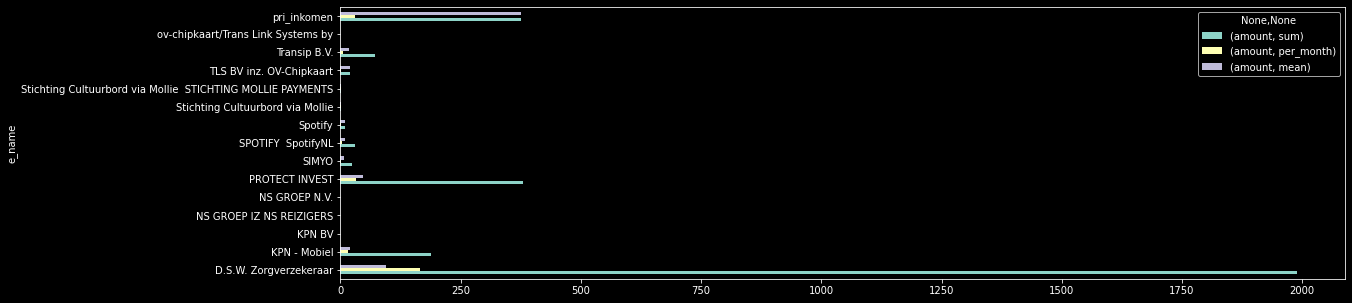

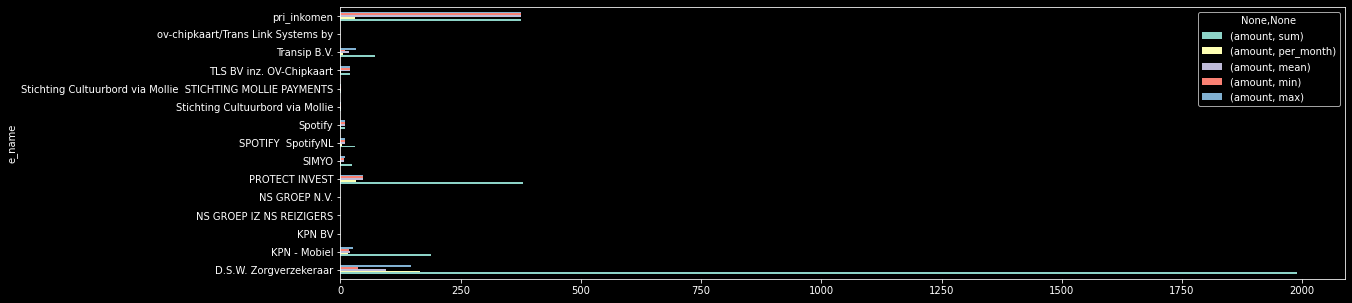

In [21]:
df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean']}).plot.barh()

df_per_category = df.groupby(['e_name']).agg({'amount': ['sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']})
df_per_category.plot.barh()
df_per_category

## Sauna

In [3]:
# df = df_pri_overig 
df = df_pri_fun 

search_term = 'thermen'

search = df[df['e_official_name'].str.contains(search_term, na=False, case=False)]
search2 = df[df['description'].str.contains(search_term, na=False, case=False)]

c = ['year', 'month','amount', 'e_official_name', 'description']
print('search1')
print(search[c])
print('search2')
print(search2[c])

df

search1
   year  month  amount                      e_official_name description
3  2021     12    85.9  Thermen Bussloo BV via St Trusted T     2569669
search2
Empty DataFrame
Columns: [year, month, amount, e_official_name, description]
Index: []


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-04,2021,12,D,5.55,0.0,5.55,NL54KNAB0604873182,pri_fun,,Snackplaza,E,None,Snackplaza,URK 04-12-2021 14:18 Pas: 0703,Betaalautomaat
1,2021-12-04,2021,12,D,13.00,0.0,13.00,NL54KNAB0604873182,pri_fun,,SumUp *Tran Loempia,E,None,SumUp *Tran Loempia,Urk 04-12-2021 08:53 Pas: 0703,Betaalautomaat
2,2021-12-04,2021,12,D,6.45,0.0,6.45,NL54KNAB0604873182,pri_fun,,Poeliersbedrijf Verhoe,E,None,Poeliersbedrijf Verhoe,ERMELO 04-12-2021 08:51 Pas: 0703,Betaalautomaat
3,2021-12-03,2021,12,D,85.90,0.0,85.90,NL54KNAB0604873182,pri_fun,NL73INGB0008936868,Thermen Bussloo BV via St Trusted T,E,None,Thermen Bussloo BV via St Trusted T,2569669,iDEAL
4,2021-12-03,2021,12,C,100.00,100.0,0.00,NL54KNAB0604873182,pri_fun,NL25KNAB0604860706,pri_inkomen,I,P,William Loosman,NaN,Ontvangen betaling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2021-01-28,2021,1,D,4.49,0.0,4.49,NL54KNAB0604873182,pri_fun,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 28-01-2021 18:38 Pas: 0703,Betaalautomaat
125,2021-01-27,2021,1,D,55.08,0.0,55.08,NL54KNAB0604873182,pri_fun,,Sligro ZB 5060,E,None,Sligro ZB 5060,NIEUWEGEIN 27-01-2021 13:45 Pas: 0703,Betaalautomaat
126,2021-01-26,2021,1,D,0.89,0.0,0.89,NL54KNAB0604873182,pri_fun,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 26-01-2021 17:32 Pas: 0703,Betaalautomaat
127,2021-01-24,2021,1,D,12.40,0.0,12.40,NL54KNAB0604873182,pri_fun,,McDonald's Lelystad,E,None,McDonald's Lelystad,LELYSTAD 24-01-2021 19:41 Pas: 0703,Betaalautomaat


## Overig

In [58]:
df = df_pri_overig
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

bol.com b.v.                     13
HORNBACH BT715 NIEUWEG           11
Infomedics B.V.                   9
ABN AMRO Bank NV                  9
't Soetendal Urkerhard            5
                                 ..
pri_stack                         1
www.spreadshirt.net via Adyen     1
HEMA EV082NIEUWEGEIN              1
Scapino Emmeloord                 1
HBM Machines B.V. by Buckaroo     1
Name: e_name, Length: 120, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-23,2021,12,D,32.50,0.0,32.50,NL55KNAB0604872291,pri_overig,NL27KNAB0259270040,Knab betaalverzoek,E,None,Knab betaalverzoek,NL15KNAB0256689571 - Breadcrumb,iDEAL
1,2021-12-20,2021,12,D,200.00,0.0,200.00,NL55KNAB0604872291,pri_overig,,Geldmaat `t Goylaan 66,E,None,Geldmaat `t Goylaan 66,Utrecht 20-12-2021 19:47 Pas: 0596,Geldautomaat
2,2021-12-18,2021,12,D,15.90,0.0,15.90,NL55KNAB0604872291,pri_overig,,CCV*Paardenslagerij W.,E,None,CCV*Paardenslagerij W.,UTRECHT 18-12-2021 11:09 Pas: 0596,Betaalautomaat
3,2021-12-17,2021,12,D,19.99,0.0,19.99,NL55KNAB0604872291,pri_overig,,Blokker204Nieuwegein,E,None,Blokker204Nieuwegein,NIEUWEGEIN 17-12-2021 16:31 Pas: 0596,Betaalautomaat
4,2021-12-09,2021,12,D,44.50,0.0,44.50,NL55KNAB0604872291,pri_overig,NL26INGB0006865503,Schiphol Nederland B.V. via CCV Gro,E,None,Schiphol Nederland B.V. via CCV Gro,Order 1E07D3,iDEAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2021-02-08,2021,2,D,3.00,0.0,3.00,NL55KNAB0604872291,pri_overig,NL13ABNA0506417344,ABN AMRO Bank NV,E,None,ABN AMRO Bank NV,Hanneke Kuipers NL23RABO0315510862,iDEAL
268,2021-02-05,2021,2,D,3.06,0.0,3.06,NL55KNAB0604872291,pri_overig,,Jumbo Urk Nagel,E,None,Jumbo Urk Nagel,URK 05-02-2021 11:07 Pas: 0596,Betaalautomaat
269,2021-02-05,2021,2,D,5.00,0.0,5.00,NL55KNAB0604872291,pri_overig,,'t Soetendal Urkerhard,E,None,'t Soetendal Urkerhard,URK 05-02-2021 10:55 Pas: 0596,Betaalautomaat
270,2021-02-03,2021,2,D,52.90,0.0,52.90,NL55KNAB0604872291,pri_overig,NL51ABNA0565668625,Gorilla Sports Nederland BV via Ady,E,None,Gorilla Sports Nederland BV via Ady,700288590,iDEAL


amount 
 
 
 
 count 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 
 
 
 
 
 
 
 
 
 
 bol.com b.v. 
 13 
 528.27 
 44.022500 
 40.636154 
 15.98 
 129.95 
 
 
 HORNBACH BT715 NIEUWEG 
 11 
 856.72 
 71.393333 
 77.883636 
 8.45 
 200.05 
 
 
 ABN AMRO Bank NV 
 9 
 168.30 
 14.025000 
 18.700000 
 3.00 
 60.00 
 
 
 Infomedics B.V. 
 9 
 384.93 
 32.077500 
 42.770000 
 42.77 
 42.77 
 
 
 't Soetendal Urkerhard 
 5 
 29.69 
 2.474167 
 5.938000 
 4.57 
 7.18 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 Geldmaat `t Goylaan 66 
 1 
 200.00 
 16.666667 
 200.000000 
 200.00 
 200.00 
 
 
 Geldmaat Plein 12A 
 1 
 140.00 
 11.666667 
 140.000000 
 140.00 
 140.00 
 
 
 Geldmaat Nagel 42 
 1 
 20.00 
 1.666667 
 20.000000 
 20.00 
 20.00 
 
 
 GAMMA 
 1 
 58.42 
 4.868333 
 58.420000 
 58.42 
 58.42 
 
 
 www.spreadshirt.net via Adyen 
 1 
 15.98 
 1.331667 
 15.980000 
 15.98 
 15.98 
 
 
 
 120 rows × 6 columns

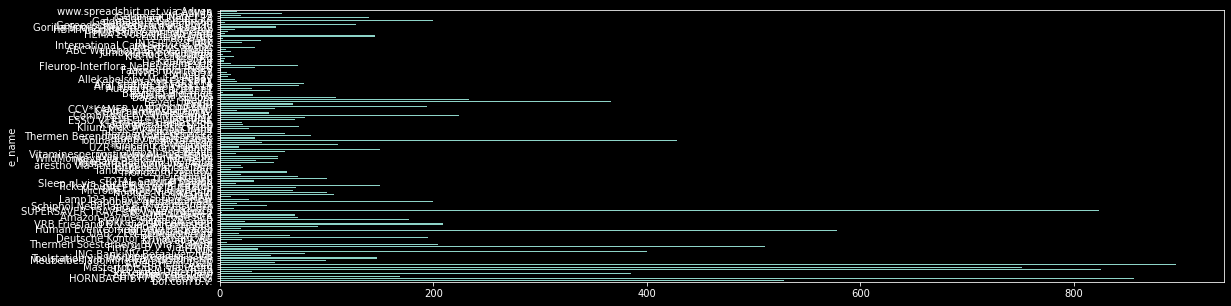

In [59]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)
df_per_category[('amount', 'sum')].plot.barh()
df_per_category

,count,amount
bol.com b.v.,13.0,528.27
HORNBACH BT715 NIEUWEG,11.0,856.72
ABN AMRO Bank NV,9.0,168.30
Infomedics B.V.,9.0,384.93
't Soetendal Urkerhard,5.0,29.69
INT CARD SERVICES,5.0,825.34
Mastertools B.V. via PAY.nl,5.0,751.03
cjib,5.0,896.00
Albert Heijn 1327,4.0,51.90
Meubelbeslagonline via Stichting Mo,4.0,99.16


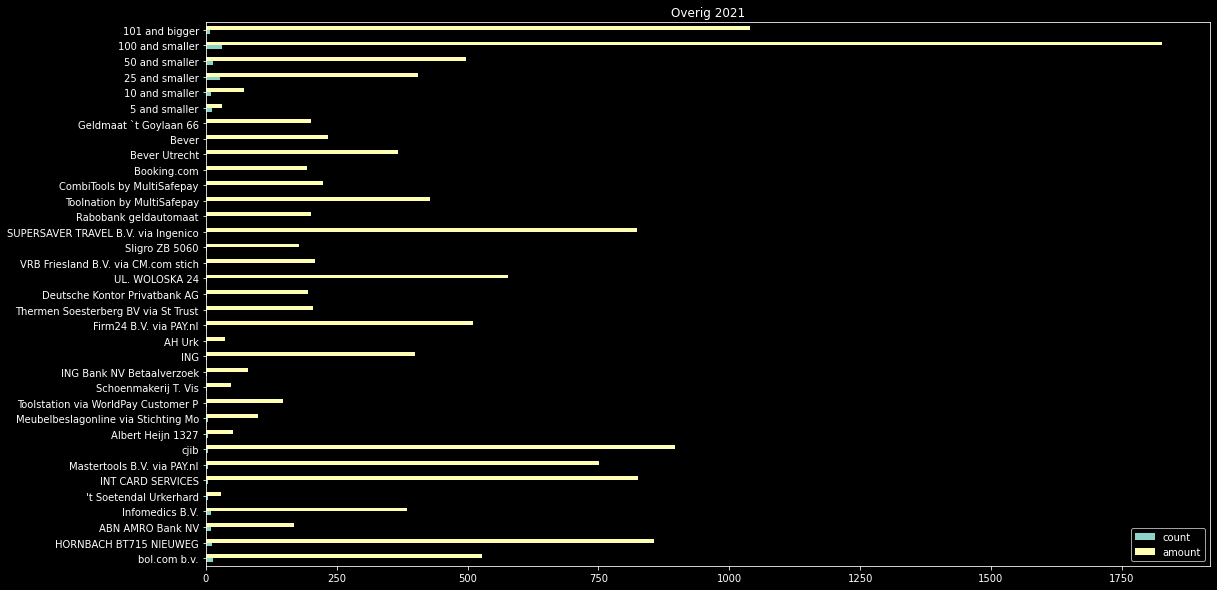

In [67]:
name = []
count = []
amount = []

aggregates = {
    5: [0, 0],
    10: [0, 0],
    25: [0, 0],
    50: [0, 0],
    100: [0, 0],
}
l = list(aggregates)
first_aggregates = l
last_aggregate = l[-1] + 1
aggregates.update({last_aggregate: [0, 0]})

def aggregate_small_values(c):
    n = c.name    
    s = c[('amount', 'sum')]
    c = c[('amount', 'count')]

    if c <= 2 and s < 151:
    
        if s < last_aggregate:
            for a in first_aggregates:
                if s <= a:
                    aggregates[a][0] += c
                    aggregates[a][1] += s
                    break
        else:
            aggregates[last_aggregate][0] += c
            aggregates[last_aggregate][1] += s
    else:
        name.append(n)
        count.append(c)
        amount.append(s)

df_per_category.apply(aggregate_small_values, axis=1)

for a in first_aggregates:
    name.append(f'{a} and smaller')
    count.append(aggregates[a][0])
    amount.append(aggregates[a][1])

name.append(f'{last_aggregate} and bigger')
count.append(aggregates[last_aggregate][0])
amount.append(aggregates[last_aggregate][1])

df_agg = pd.DataFrame(index=name, data={'count': count, 'amount': amount})

plt.rcParams["figure.figsize"] = (18,10)
df_agg.plot.barh(title='Overig 2021')
plt.rcParams["figure.figsize"] = (18,5)

df_agg

# pin

In [38]:
df_pin = df[df['amount'] >= 149]
df_pin = df_pin[df_pin['payment_type'] == 'Geldautomaat']

b = sum(df_pin['amount']) - 200
pm = round(b / 12, 2)

print('Pin: €', b)
print('P.M.: €', )
print('% van I: ', round(pm / 2100 * 100), '%')

df_pin

Pin: € 550.0
P.M.: €
% van I:  2 %


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
1,2021-12-20,2021,12,D,200.0,0.0,200.0,NL55KNAB0604872291,pri_overig,,Geldmaat `t Goylaan 66,E,None,Geldmaat `t Goylaan 66,Utrecht 20-12-2021 19:47 Pas: 0596,Geldautomaat
126,2021-07-17,2021,7,D,200.0,0.0,200.0,NL55KNAB0604872291,pri_overig,,Rabobank geldautomaat,E,None,Rabobank geldautomaat,NOORDOOSTPOLD 17-07-2021 12:26 Pas: 0596,Geldautomaat
142,2021-06-30,2021,6,D,200.0,0.0,200.0,NL55KNAB0604872291,pri_overig,,ING,E,None,ING,NIEUWEGEIN 30-06-2021 20:58 Pas: 0596,Geldautomaat
173,2021-06-05,2021,6,D,150.0,0.0,150.0,NL55KNAB0604872291,pri_overig,,ING,E,None,ING,NIEUWEGEIN 05-06-2021 18:32 Pas: 0596,Geldautomaat


### Boetes!!!

In [4]:
# df_boete = df.loc[df['e_name'] == 'cjib']

search_term = 'cjib'
df_boete = df[df['e_official_name'].str.contains(search_term, na=False, case=False)]

print(df_boete['amount'])

costs = sum(df_boete['amount'])

print("Boetes: €", costs)
print("Per maand: €", round(costs / 12, 2))

10    233.0
12    109.0
68    197.0
69    248.0
81    109.0
Name: amount, dtype: float64
Boetes: € 896.0
Per maand: € 74.67


In [5]:
# df[df['description'].str.contains(search_term, na=False, case=False)]

df_boete = df.loc[df['description'] == '8062542246114392']
df_boete

,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
10,2021-12-07,2021,12,D,233.0,0.0,233.0,NL55KNAB0604872291,pri_overig,NL56INGB0705005100,cjib,E,None,cjib,8062542246114392,Acceptgiro


## Boodschappen

In [68]:
df = df_pri_boodschappen
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

Albert Heijn 1327         136
AH Urk                     22
Bakkerij Brouwer           18
Jumbo Den Bosch Hofv       15
CCV*Gebroeders van Hez      8
                         ... 
ORLEN STACJA NR 440         1
ZABKA Z3773 K.1             1
Netto Marken-Discount       1
Alnatura Produktions u      1
Dekamarkt LOC527            1
Name: e_name, Length: 62, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-06,2021,12,D,12.49,0.0,12.49,NL60KNAB0604871716,pri_boodschappen,,Jumbo Den Bosch Hofv,E,None,Jumbo Den Bosch Hofv,'S-HERTOGENBO 06-12-2021 09:50 Pas: 0562,Betaalautomaat
1,2021-12-03,2021,12,D,5.49,0.0,5.49,NL60KNAB0604871716,pri_boodschappen,,AH Urk,E,None,AH Urk,URK 03-12-2021 08:42 Pas: 0562,Betaalautomaat
2,2021-12-02,2021,12,D,22.49,0.0,22.49,NL60KNAB0604871716,pri_boodschappen,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 02-12-2021 13:23 Pas: 0562,Betaalautomaat
3,2021-12-01,2021,12,D,6.50,0.0,6.50,NL60KNAB0604871716,pri_boodschappen,,CCV*MAALTIJD PLUS GRIL,E,None,CCV*MAALTIJD PLUS GRIL,NIEUWEGEIN 01-12-2021 12:48 Pas: 0562,Betaalautomaat
4,2021-12-01,2021,12,D,9.60,0.0,9.60,NL60KNAB0604871716,pri_boodschappen,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 01-12-2021 12:45 Pas: 0562,Betaalautomaat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,2021-01-27,2021,1,D,23.92,0.0,23.92,NL60KNAB0604871716,pri_boodschappen,,Sligro ZB 5060,E,None,Sligro ZB 5060,NIEUWEGEIN 27-01-2021 13:45 Pas: 0562,Betaalautomaat
304,2021-01-26,2021,1,D,3.54,0.0,3.54,NL60KNAB0604871716,pri_boodschappen,,Albert Heijn 1327,E,None,Albert Heijn 1327,NIEUWEGEIN 26-01-2021 17:32 Pas: 0562,Betaalautomaat
305,2021-01-23,2021,1,D,3.65,0.0,3.65,NL60KNAB0604871716,pri_boodschappen,,Jumbo Doetinchem,E,None,Jumbo Doetinchem,DOETINCHEM 23-01-2021 15:34 Pas: 0562,Betaalautomaat
306,2021-01-23,2021,1,D,3.07,0.0,3.07,NL60KNAB0604871716,pri_boodschappen,,Dekamarkt LOC527,E,None,Dekamarkt LOC527,DOETINCHEM 23-01-2021 13:16 Pas: 0562,Betaalautomaat


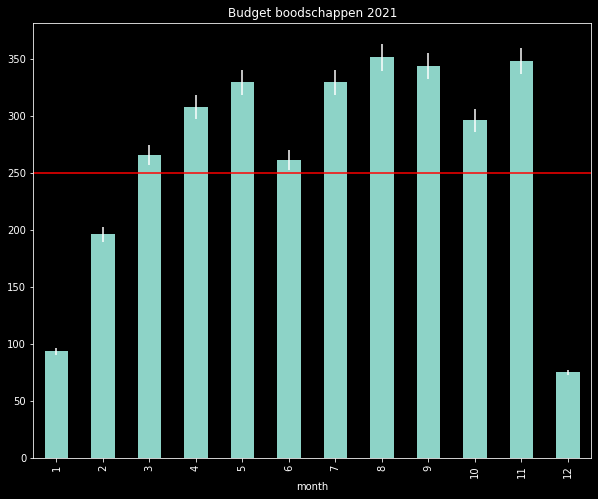

amount 
 
 
 
 count 
 sum 
 per_day 
 mean 
 min 
 max 
 
 
 month 
 
 
 
 
 
 
 
 
 
 
 1 
 9 
 93.60 
 3.120000 
 10.400000 
 0.99 
 33.50 
 
 
 2 
 22 
 196.47 
 6.549000 
 8.930455 
 0.99 
 31.37 
 
 
 3 
 23 
 265.98 
 8.866000 
 11.564348 
 1.39 
 27.10 
 
 
 4 
 31 
 308.14 
 10.271333 
 9.940000 
 0.20 
 27.20 
 
 
 5 
 28 
 329.57 
 10.985667 
 11.770357 
 0.74 
 40.75 
 
 
 6 
 22 
 261.85 
 8.728333 
 11.902273 
 1.39 
 43.70 
 
 
 7 
 31 
 329.70 
 10.990000 
 10.635484 
 0.92 
 50.90 
 
 
 8 
 26 
 351.63 
 11.721000 
 13.524231 
 1.33 
 37.12 
 
 
 9 
 28 
 343.84 
 11.461333 
 12.280000 
 2.54 
 43.73 
 
 
 10 
 27 
 296.27 
 9.875667 
 10.972963 
 2.66 
 36.75 
 
 
 11 
 37 
 348.41 
 11.613667 
 9.416486 
 2.25 
 26.89 
 
 
 12 
 6 
 75.10 
 2.503333 
 12.516667 
 5.49 
 22.49

In [149]:
budget = 250

df_per_month = df.groupby(['month']) \
                             .agg({'amount': ['count',  'sum', ('per_day', lambda v: v.sum() / 30), 'mean', 'min', 'max']})


%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8))



plt.plot([-1, 12], [budget, budget], color='red')

ax = df_per_month[('amount', 'sum')].plot.bar(ax=axes, yerr=df_per_month[('amount','per_day')], title='Budget boodschappen 2021')

plt.show()

df_per_month

In [135]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)

df_per_category

amount 
 
 
 
 count 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 
 
 
 
 
 
 
 
 
 
 Albert Heijn 1327 
 136 
 1712.65 
 142.720833 
 12.593015 
 0.85 
 37.12 
 
 
 AH Urk 
 22 
 139.41 
 11.617500 
 6.336818 
 0.20 
 18.09 
 
 
 Bakkerij Brouwer 
 18 
 86.00 
 7.166667 
 4.777778 
 2.32 
 12.71 
 
 
 Jumbo Den Bosch Hofv 
 15 
 100.05 
 8.337500 
 6.670000 
 3.71 
 12.49 
 
 
 CCV*Gebroeders van Hez 
 8 
 120.73 
 10.060833 
 15.091250 
 4.68 
 27.10 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 Esso Eemnes Eemakker 
 1 
 4.00 
 0.333333 
 4.000000 
 4.00 
 4.00 
 
 
 Het Oude Pothuys 
 1 
 19.20 
 1.600000 
 19.200000 
 19.20 
 19.20 
 
 
 Jumbo Arnhem AW 
 1 
 9.90 
 0.825000 
 9.900000 
 9.90 
 9.90 
 
 
 Jumbo Doetinchem 
 1 
 3.65 
 0.304167 
 3.650000 
 3.65 
 3.65 
 
 
 itizi B.V. via Mollie 
 1 
 50.90 
 4.241667 
 50.900000 
 50.90 
 50.90 
 
 
 
 62 rows × 6 columns

,count,amount
Albert Heijn 1327,136.0,1712.65
AH Urk,22.0,139.41
Bakkerij Brouwer,18.0,86.00
Jumbo Den Bosch Hofv,15.0,100.05
CCV*Gebroeders van Hez,8.0,120.73
Albert Heijn 1863,7.0,99.66
CCV*Paardenslagerij W.,4.0,91.10
CCV*MAALTIJD PLUS GRIL,4.0,35.09
ING Bank NV Betaalverzoek,4.0,45.86
Jumbo Nieuwegein Wal,4.0,18.44


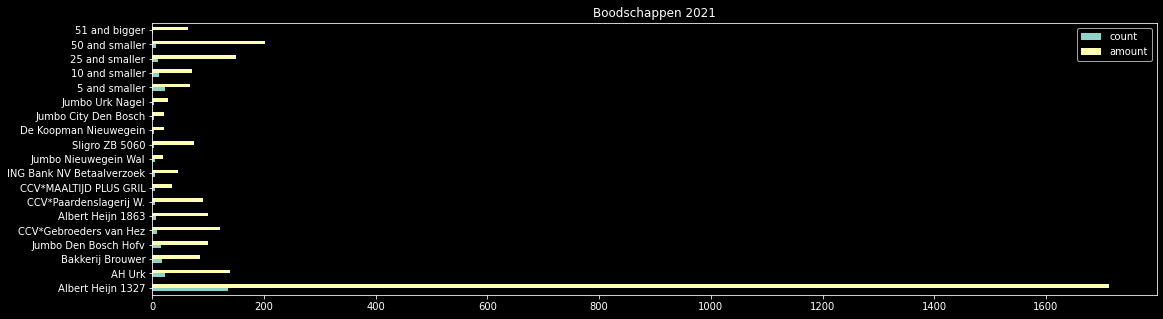

In [136]:
name = []
count = []
amount = []

aggregates = {
    5: [0, 0],
    10: [0, 0],
    25: [0, 0],
    50: [0, 0],
}
l = list(aggregates)
first_aggregates = l
last_aggregate = l[-1] + 1
aggregates.update({last_aggregate: [0, 0]})

def aggregate_small_values(c):
    n = c.name    
    s = c[('amount', 'sum')]
    c = c[('amount', 'count')]

    if c <= 2:
    
        if s < last_aggregate:
            for a in first_aggregates:
                if s <= a:
                    aggregates[a][0] += c
                    aggregates[a][1] += s
                    break
        else:
            aggregates[last_aggregate][0] += c
            aggregates[last_aggregate][1] += s
    else:
        name.append(n)
        count.append(c)
        amount.append(s)

df_per_category.apply(aggregate_small_values, axis=1)

for a in first_aggregates:
    name.append(f'{a} and smaller')
    count.append(aggregates[a][0])
    amount.append(aggregates[a][1])

name.append(f'{last_aggregate} and bigger')
count.append(aggregates[last_aggregate][0])
amount.append(aggregates[last_aggregate][1])

df_agg = pd.DataFrame(index=name, data={'count': count, 'amount': amount})

df_agg.plot.barh(title='Boodschappen 2021')

df_agg

## Huis

In [151]:
df = df_huis_inkomen_en_lasten
df = df.loc[df['credit_or_debet'] == 'D']

print(df['e_name'].value_counts())

df

ASSURADEUREN GILDE BV    7
huis_hypotheek           7
Knab                     6
KPN B.V.                 6
ENERGIEDIRECT BV         5
VITENS NV                4
huis_huishoudelijk       3
huis_spaar               2
pri_inkomen              2
huis_klussen             2
bol.com b.v.             1
M.J. de Vries            1
pri_overig               1
Geobureau                1
Name: e_name, dtype: int64


,date,year,month,credit_or_debet,amount,credit,debet,i_number,i_name,e_number,e_name,internal_or_external,e_type,e_official_name,description,payment_type
0,2021-12-01,2021,12,D,1591.13,0.0,1591.13,NL02KNAB0407458360,huis_inkomen_en_lasten,57857884,huis_spaar,I,S,W. J. Loosman en/of T. Hakvoort,NaN,Overboeking
1,2021-12-01,2021,12,D,5.00,0.0,5.00,NL02KNAB0407458360,huis_inkomen_en_lasten,80000208,Knab,E,None,Knab,Pakketkosten,Pakketkosten
2,2021-12-01,2021,12,D,56.07,0.0,56.07,NL02KNAB0407458360,huis_inkomen_en_lasten,NL90INGB0666496846,ASSURADEUREN GILDE BV,E,None,ASSURADEUREN GILDE BV,KENMERK 1124138 Pakketpremie A-gilde privepakk...,Periodieke incasso
4,2021-11-30,2021,11,D,1070.00,0.0,1070.00,NL02KNAB0407458360,huis_inkomen_en_lasten,NL55INGB0798628839,huis_hypotheek,I,P,W.J. Loosman,Hypotheek,Periodieke overboeking
7,2021-11-26,2021,11,D,24.01,0.0,24.01,NL02KNAB0407458360,huis_inkomen_en_lasten,NL94INGB0000869000,VITENS NV,E,None,VITENS NV,Factuurnr 071606961089 VNKlantnr 2002802523 BT...,Periodieke incasso
9,2021-11-25,2021,11,D,182.00,0.0,182.00,NL02KNAB0407458360,huis_inkomen_en_lasten,NL71ABNA0629639183,ENERGIEDIRECT BV,E,None,ENERGIEDIRECT BV,100390273517/KLANT 132730457 KNMRK 200626213/F...,Periodieke incasso
11,2021-11-08,2021,11,D,51.45,0.0,51.45,NL02KNAB0407458360,huis_inkomen_en_lasten,NL41INGB0000467598,KPN B.V.,E,None,KPN B.V.,"Factuur 03-11-2021 incl. 8,93 BTW, klantnummer...",Periodieke incasso
12,2021-11-02,2021,11,D,56.07,0.0,56.07,NL02KNAB0407458360,huis_inkomen_en_lasten,NL90INGB0666496846,ASSURADEUREN GILDE BV,E,None,ASSURADEUREN GILDE BV,KENMERK 1124138 Pakketpremie A-gilde privepakk...,Periodieke incasso
17,2021-11-01,2021,11,D,5.00,0.0,5.00,NL02KNAB0407458360,huis_inkomen_en_lasten,80000208,Knab,E,None,Knab,Pakketkosten,Pakketkosten
18,2021-11-01,2021,11,D,1070.00,0.0,1070.00,NL02KNAB0407458360,huis_inkomen_en_lasten,NL55INGB0798628839,huis_hypotheek,I,P,W.J. Loosman,Hypotheek,Periodieke overboeking


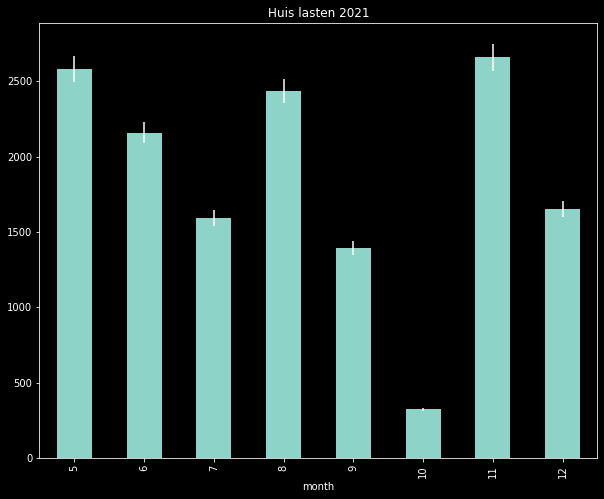

amount 
 
 
 
 count 
 sum 
 per_day 
 mean 
 min 
 max 
 
 
 month 
 
 
 
 
 
 
 
 
 
 
 5 
 5 
 2580.32 
 86.010667 
 516.064000 
 41.22 
 1070.00 
 
 
 6 
 8 
 2158.64 
 71.954667 
 269.830000 
 26.94 
 1070.00 
 
 
 7 
 7 
 1589.96 
 52.998667 
 227.137143 
 5.00 
 1213.00 
 
 
 8 
 6 
 2434.52 
 81.150667 
 405.753333 
 5.00 
 1070.00 
 
 
 9 
 6 
 1394.52 
 46.484000 
 232.420000 
 5.00 
 1070.00 
 
 
 10 
 5 
 322.97 
 10.765667 
 64.594000 
 5.00 
 182.00 
 
 
 11 
 8 
 2658.53 
 88.617667 
 332.316250 
 5.00 
 1070.00 
 
 
 12 
 3 
 1652.20 
 55.073333 
 550.733333 
 5.00 
 1591.13

In [160]:
budget = 250

df_per_month = df.groupby(['month']) \
                             .agg({'amount': ['count',  'sum', ('per_day', lambda v: v.sum() / 30), 'mean', 'min', 'max']})


%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8))



# plt.plot([-1, 12], [budget, budget], color='red')

ax = df_per_month[('amount', 'sum')].plot.bar(ax=axes, yerr=df_per_month[('amount','per_day')], title='Huis lasten 2021')

plt.show()

df_per_month

amount 
 
 
 
 count 
 sum 
 per_month 
 mean 
 min 
 max 
 
 
 e_name 
 
 
 
 
 
 
 
 
 
 
 ASSURADEUREN GILDE BV 
 7 
 392.49 
 32.707500 
 56.070000 
 56.07 
 56.07 
 
 
 huis_hypotheek 
 7 
 7490.00 
 624.166667 
 1070.000000 
 1070.00 
 1070.00 
 
 
 KPN B.V. 
 6 
 307.25 
 25.604167 
 51.208333 
 50.00 
 51.45 
 
 
 Knab 
 6 
 30.00 
 2.500000 
 5.000000 
 5.00 
 5.00 
 
 
 ENERGIEDIRECT BV 
 5 
 910.00 
 75.833333 
 182.000000 
 182.00 
 182.00 
 
 
 VITENS NV 
 4 
 147.67 
 12.305833 
 36.917500 
 24.01 
 41.22 
 
 
 huis_huishoudelijk 
 3 
 580.00 
 48.333333 
 193.333333 
 30.00 
 350.00 
 
 
 huis_klussen 
 2 
 434.55 
 36.212500 
 217.275000 
 200.00 
 234.55 
 
 
 huis_spaar 
 2 
 2804.13 
 233.677500 
 1402.065000 
 1213.00 
 1591.13 
 
 
 pri_inkomen 
 2 
 1026.94 
 85.578333 
 513.470000 
 26.94 
 1000.00 
 
 
 Geobureau 
 1 
 234.55 
 19.545833 
 234.550000 
 234.55 
 234.55 
 
 
 M.J. de Vries 
 1 
 366.66 
 30.555000 
 366.660000 
 366.66 
 366.66 
 
 
 bol.com b.v. 
 1 
 28.45 
 2.370833 
 28.450000 
 28.45 
 28.45 
 
 
 pri_overig 
 1 
 38.97 
 3.247500 
 38.970000 
 38.97 
 38.97

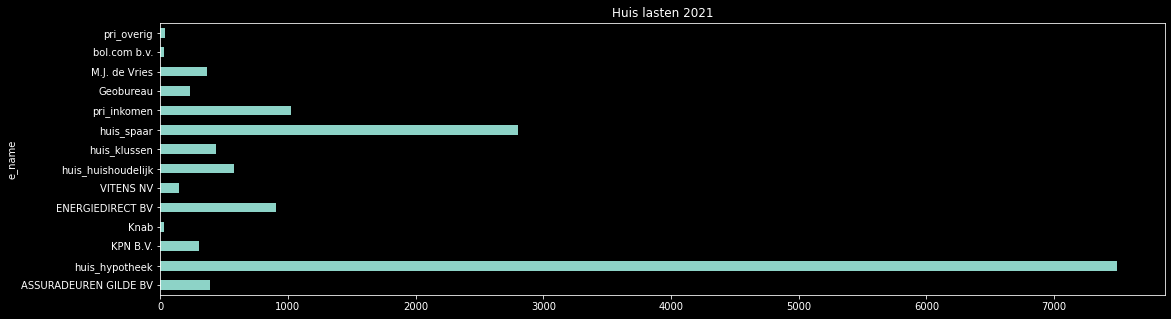

In [159]:
df_per_category = df.groupby(['e_name']) \
                             .agg({'amount': ['count',  'sum', ('per_month', lambda v: v.sum() / 12), 'mean', 'min', 'max']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)

df_per_category[('amount','sum')].plot.barh(title='Huis lasten 2021')

df_per_category

# Sheet 2

In [15]:
import re

re.sub(' +', ' ', 'The     quick brown    fox')

'The quick brown fox'

amount 
 
 
 
 count 
 sum 
 
 
 name 
 
 
 
 
 
 
 b 
 3 
 12 
 
 
 a 
 2 
 7 
 
 
 c 
 1 
 2 
 
 
 d 
 1 
 4 
 
 
 e 
 1 
 1

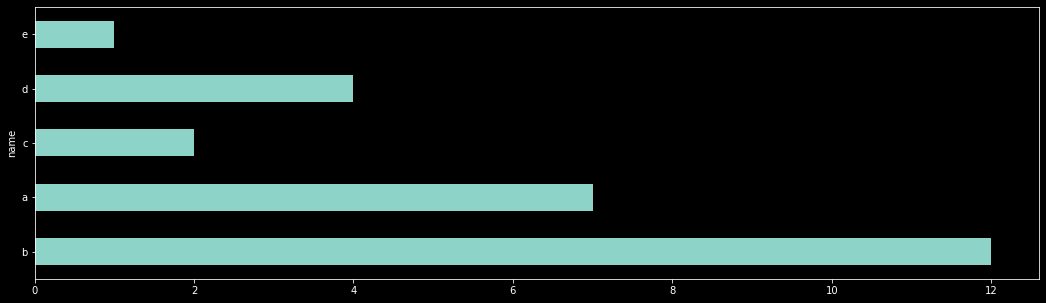

In [5]:
d = {'name': ['a', 'a', 'b', 'b', 'b', 'c', 'd', 'e'], 'amount': [2, 5, 2, 3, 7, 2, 4, 1]}
df = pd.DataFrame(data=d)

df_per_category = df.groupby(['name']) \
                             .agg({'amount': ['count',  'sum']}) \
                             .sort_values(by=[('amount', 'count')], ascending=False)

df_per_category[('amount', 'sum')].plot.barh()
df_per_category

In [24]:
aggregates = {
    5: 0,
    10: 0,
    50: 0,
    100: 0,
}

for a in aggregates:
    print(a, aggregates[a])

5 0
10 0
50 0
100 0


In [50]:
# 7.58 <= 50 and not 7.58 > 50
# 50 and smaller

# 7.58 <= 50 #and not 7.58 > 50

7.58 > 50

False